In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary,\
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

# Предобработка текстов и подготовка признаков

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print(f"Кол-во обучающих текстов - {len(train_source['data'])}")
print(f"Кол-во тестовых текстов - {len(test_source['data'])}")
print()
print(train_source['data'][0].strip())

print()
print(f"Метка - {train_source['target'][0]}")

Кол-во обучающих текстов - 11314
Кол-во тестовых текстов - 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка - 7


### Подготовка признаков

In [3]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [4]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized,
                                             max_doc_freq=MAX_DF,
                                             min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print(f"Кол-во уникальных токенов - {UNIQUE_WORDS_N}")
print(list(vocabulary.items())[:10])

Кол-во уникальных токенов - 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


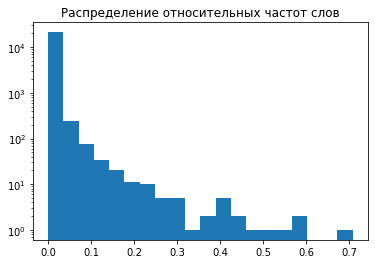

In [5]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log')

In [6]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print(f'Размерность матрицы признаков обучающей выборки - {train_vectors.shape}')
print(f'Размерность матрицы признаков тестовой выборки - {test_vectors.shape}')
print()
print(f'Кол-во ненулевых элементов в обучающей выборке - {train_vectors.nnz}')
print('Процент заполненности матрицы признаков {:.2f}%'.format(
    train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print(f'Кол-во ненулевых элементов в тестовой выборке - {test_vectors.nnz}')
print('Процент заполненности матрицы признаков {:.2f}%'.format(
    test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки - (11314, 21628)
Размерность матрицы признаков тестовой выборки - (7532, 21628)

Кол-во ненулевых элементов в обучающей выборке - 1126792
Процент заполненности матрицы признаков 0.46%
Кол-во ненулевых элементов в тестовой выборке - 721529
Процент заполненности матрицы признаков 0.44%


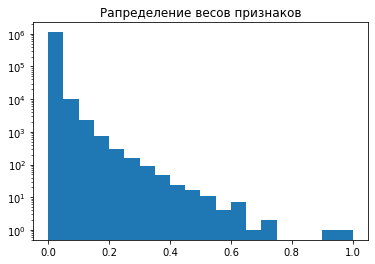

In [7]:
plt.hist(train_vectors.data, bins=20)
plt.title('Рапределение весов признаков')
plt.yscale('log')

### Распределение классов

In [8]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print(f'Кол-во уникальных меток - {UNIQUE_LABELS_N}')

Кол-во уникальных меток - 20


Text(0.5, 1.0, 'Распределение меток в обучающей выборке')

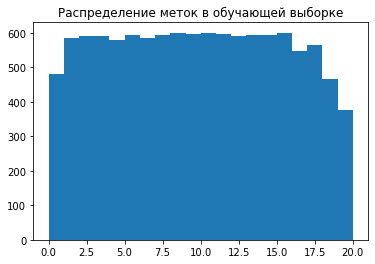

In [9]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке')

Text(0.5, 1.0, 'Распределение меток в тестовой выборке')

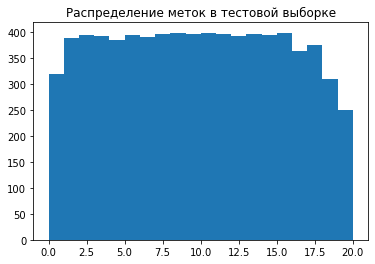

In [10]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке')

### PyTorch Dataset

In [11]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

# Обучение модели на PyTorch

In [12]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

def lr_scheduler(optim):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                      patience=5,
                                                      factor=0.5,
                                                      verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 354 итераций, 2.44 сек
Среднее значение функции потерь на обучении 2.225263512740701
Среднее значение функции потерь на валидации 2.113702099202043
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 2.44 сек
Среднее значение функции потерь на обучении 0.9165941316024059
Среднее значение функции потерь на валидации 1.6821965161016432
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 2.47 сек
Среднее значение функции потерь на обучении 0.4660179071170462
Среднее значение функции потерь на валидации 1.4643912370932304
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 2.42 сек
Среднее значение функции потерь на обучении 0.2836364033279446
Среднее значение функции потерь на валидации 1.3450380030830027
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 2.55 сек
Среднее значение функции потерь на обучении 0.19072467734837262
Среднее значение функции потерь на валидации 1.2602417269500636
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 2.50 сек
Среднее значение функции пот

### Оценка качества

In [13]:
train_pred = predict_with_model(best_model, train_dataset)
train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())
print(f'Среднее значение функции потерь на обучении - {float(train_loss)}')
print(f"Доле верных ответов - {accuracy_score(train_source['target'], train_pred.argmax(-1))}")
print()
test_pred = predict_with_model(best_model, test_dataset)
test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                             torch.from_numpy(test_source['target']).long())
print(f'Среднее значение функции потерь на валидации - {float(test_loss)}')
print(f"Доле верных ответов - {accuracy_score(test_source['target'], test_pred.argmax(-1))}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/353.5625 [00:01<00:00, 213.57it/s]
  9%|██████████████▉                                                                                                                                                        | 21/235.375 [00:00<00:01, 204.36it/s]

Среднее значение функции потерь на обучении - 0.0022322225850075483
Доле верных ответов - 0.9994696835778681



236it [00:01, 211.28it/s]                                                                                                                                                                                         

Среднее значение функции потерь на валидации - 0.9289414286613464
Доле верных ответов - 0.76805629314923


# Альтернативаня реализация на scikit-learn

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target'])

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.8, min_df=5,
                                 tokenizer=<function tokenize_text_simple_regex at 0x000001F543B08AF0>)),
                ('cls', LogisticRegression())])

### Оценка качества

In [15]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                     torch.from_numpy(train_source['target']).long())
print(f'Среднее значение функции потерь на обучении - {float(sklearn_train_loss)}')
print(f"Доле верных ответов - {accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1))}")
print()
sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                     torch.from_numpy(test_source['target']).long())
print(f'Среднее значение функции потерь на валидации - {float(sklearn_test_loss)}')
print(f"Доле верных ответов - {accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1))}")

Среднее значение функции потерь на обучении - 2.4954788918518926
Доле верных ответов - 0.9716280714159449

Среднее значение функции потерь на валидации - 2.653902258228598
Доле верных ответов - 0.8190387679235263
